# **Campaign Prediction**

# 1. Description
---

- The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

Input variables:
##### A. bank client data:
- 1 - age (numeric)
- 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- 5 - default: has credit in default? (categorical: 'no','yes','unknown')
- 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
- 7 - loan: has personal loan? (categorical: 'no','yes','unknown')
##### B. related with the last contact of the current campaign:
- 8 - contact: contact communication type (categorical: 'cellular','telephone')
- 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
##### C. other attributes:
- 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- 14 - previous: number of contacts performed before this campaign and for this client (numeric)
- 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
##### D. social and economic context attributes
- 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
- 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
- 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
- 20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target): 
- 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

# 2. Import Libraries
---

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split 
import scipy.stats as stats

from sklearn.linear_model import LogisticRegression 
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier


# 3. Data Loading
---

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

The data set had 41188 data and 21 columns

In [5]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


# 4. Data Cleaning
---

In [6]:
# Change the name y column to term_deposit

df.rename(columns={'y': 'term_deposit'}, inplace=True)

- Based on description explained that the 999 value in pdays column indicated the client never contacted. So we'll replace 999 to NaN.  

In [7]:
df['pdays'].replace(to_replace={999: np.nan}, inplace=True)

# 5. EDA
---

In [8]:
print('Numeric Columns:',df.select_dtypes(include=np.number).columns.tolist())
print('Category columns:', df.select_dtypes(include=['object']).columns.tolist())

Numeric Columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Category columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'term_deposit']


- The data set have 10 numeric columns & 11 category columns

In [9]:
df['education'].value_counts()*100/len(df)

university.degree      29.542585
high.school            23.101389
basic.9y               14.676605
professional.course    12.729436
basic.4y               10.138875
basic.6y                5.564728
unknown                 4.202680
illiterate              0.043702
Name: education, dtype: float64

- University degree is the most client in the bank

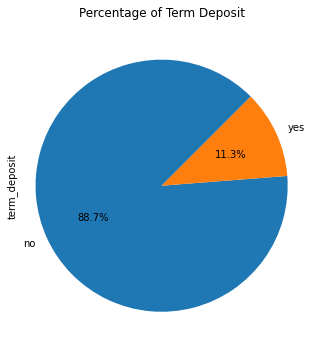

In [10]:
perc_tot_term_dep = df['term_deposit'].value_counts()*100/len(df)

perc_tot_term_dep.plot(kind='pie',
            figsize=(5,6),
            autopct='%1.1f%%',
            startangle=45,
            shadow=False)

plt.title('Percentage of Term Deposit')
plt.axis('equal')

plt.show()

- Many of clients didn't had a term deposit

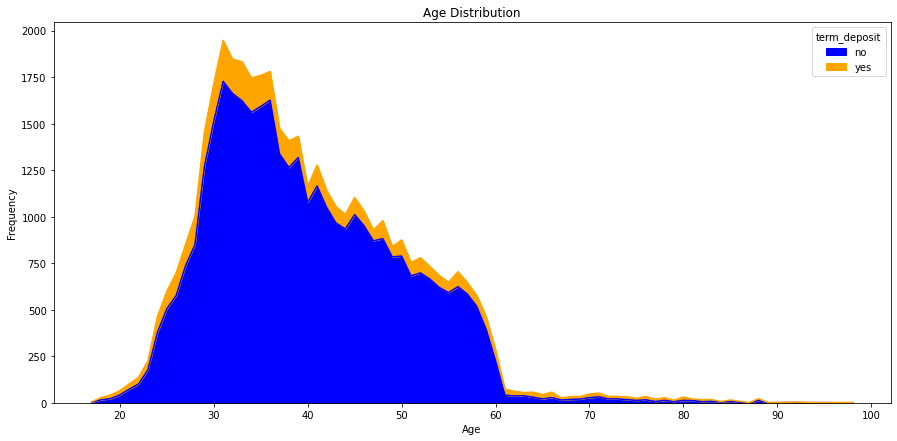

In [11]:
pd.crosstab(df.age,df.term_deposit).plot(kind="area",figsize=(15,7),color=['blue','orange' ])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

- Many of clients at 24 - 60 years old had term deposit

<AxesSubplot:xlabel='job', ylabel='count'>

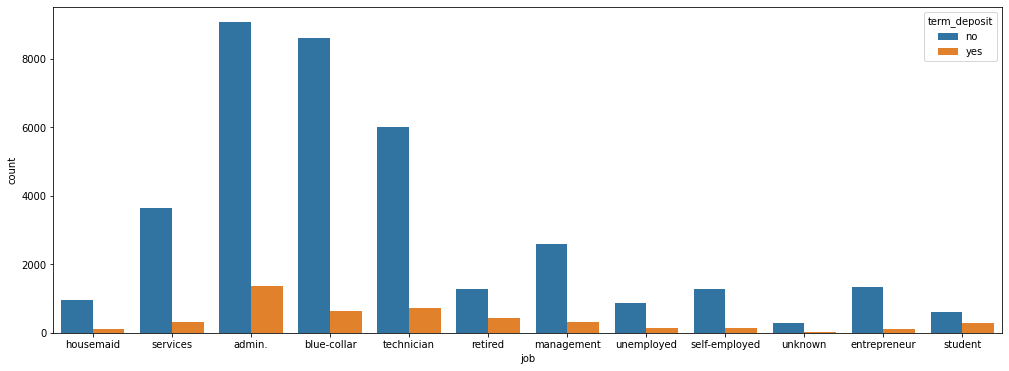

In [12]:
plt.figure(figsize = (17, 6))
sns.countplot('job', hue = 'term_deposit', data = df)

- Many of client with profession as a admin had term deposit

In [13]:
loan_vs_term_deposit=pd.crosstab(df["loan"],df["term_deposit"])
stat, p, dof, expected = stats.chi2_contingency(loan_vs_term_deposit)
print('p=%.3f' % (p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

p=0.579
Probably independent


In [14]:
housing_vs_term_deposit = pd.crosstab(df["housing"],df["term_deposit"])
stat, p, dof, expected = stats.chi2_contingency(housing_vs_term_deposit)
print('p=%.3f' % (p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

p=0.058
Probably independent


- Loan & housing didn't have significant correlation with term_deposit, or these variables are independent.

# 6. Data Preprocessing
---

## A. Get the Data Inference

In [15]:
df_inf = df.sample(50, random_state=33)

In [16]:
df_train_test = df.drop(df_inf.index)

In [17]:
df_train_test.reset_index(drop=True, inplace=True) 
df_inf.reset_index(drop=True, inplace=True) 

## B. Data Split

In [18]:
X = df_train_test.drop(['term_deposit'], axis=1)
y = df_train_test['term_deposit']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=33)

print(X_train.shape)
print(X_test.shape)

(32910, 20)
(8228, 20)


## C. Handling Outlier

For handling outliers we make a rules:
- if the outliers < 5% trimming action needed
- if the outliers > 5% capping action needed
- if the data set has a capping method in one of their column, we will use a capping method because the capping method doesn't remove the data

In [20]:
X_train_distr = pd.DataFrame({'columns':X_train.describe().columns, 'skew' : X_train.skew(axis=0)})
X_train_distr.reset_index(drop=True, inplace=True)
X_train_distr['distribution'] = np.where((X_train_distr['skew'] < 0.5) & (X_train_distr['skew'] > - 0.5) , 'Normal', 'Skew')
X_train_distr

,columns,skew,distribution
0,age,0.785009,Skew
1,duration,3.283965,Skew
2,campaign,4.675880,Skew
3,pdays,1.407959,Skew
4,previous,3.822629,Skew
5,emp.var.rate,-0.727496,Skew
6,cons.price.idx,-0.228864,Normal
7,cons.conf.idx,0.299849,Normal
8,euribor3m,-0.713028,Skew
9,nr.employed,-1.049371,Skew


- Majority of numeric columns in data set have a skew distribution

In [21]:
def find_normal_boundaries(df, variable):
    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary

def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower = df[variable].quantile(0.25) - distance * IQR
    upper = df[variable].quantile(0.75) + distance * IQR

    return upper, lower

In [22]:
j = 0
outliers={}
for i in X_train.describe().columns:
    if X_train_distr['distribution'].loc[(X_train_distr['columns']==i)].values[0]== 'Normal':
        upper_boundary, lower_boundary = find_normal_boundaries(X_train, i)
        print(f"Boundary Lower and Upper {i}:{lower_boundary, upper_boundary}")
        outliers[f"outliers{j}"] = np.where(X_train[i] > upper_boundary, True, np.where(X_train[i] < lower_boundary, True, False))
    else:
        upper_boundary, lower_boundary = find_skewed_boundaries(X_train, i, 1.5)
        print(f"Batas lower dan upper untuk {i}:{lower_boundary, upper_boundary}")
        outliers[f"outliers{j}"] = np.where(X_train[i] > upper_boundary, True, np.where(X_train[i] < lower_boundary, True, False))
    print("="*30)
    j+=1

Batas lower dan upper untuk age:(9.5, 69.5)
Batas lower dan upper untuk duration:(-226.5, 649.5)
Batas lower dan upper untuk campaign:(-2.0, 6.0)
Batas lower dan upper untuk pdays:(-3.0, 13.0)
Batas lower dan upper untuk previous:(0.0, 0.0)
Batas lower dan upper untuk emp.var.rate:(-6.6000000000000005, 6.200000000000001)
Boundary Lower and Upper cons.price.idx:(91.8439570695629, 95.31101971560877)
Boundary Lower and Upper cons.conf.idx:(-54.35596111452301, -26.657894856306523)
Batas lower dan upper untuk euribor3m:(-4.081499999999999, 10.3865)
Batas lower dan upper untuk nr.employed:(4905.6, 5421.6)


In [23]:
for i, (k, v) in enumerate(outliers.items()):
    X_train_distr_handling= X_train.loc[~outliers[k]]
    X_train_distr.loc[i,'trimmed_row'] = X_train.shape[0] - X_train_distr_handling.shape[0]
    X_train_distr.loc[i,'percentage'] = np.round(100-(X_train_distr_handling.shape[0]/X_train.shape[0]*100), 2)
    X_train_distr.loc[i,'action'] = np.where(X_train_distr.loc[i,'percentage']==0, 'No Action', 
                                        np.where(X_train_distr.loc[i,'percentage']>5, 'Capping/Windsorizer', 'Trimming'))
                                    
                                        

In [24]:
X_train_distr

,columns,skew,distribution,trimmed_row,percentage,action
0,age,0.785009,Skew,366.0,1.11,Trimming
1,duration,3.283965,Skew,2371.0,7.20,Capping/Windsorizer
2,campaign,4.675880,Skew,1918.0,5.83,Capping/Windsorizer
3,pdays,1.407959,Skew,64.0,0.19,Trimming
4,previous,3.822629,Skew,4473.0,13.59,Capping/Windsorizer
5,emp.var.rate,-0.727496,Skew,0.0,0.00,No Action
6,cons.price.idx,-0.228864,Normal,0.0,0.00,No Action
7,cons.conf.idx,0.299849,Normal,0.0,0.00,No Action
8,euribor3m,-0.713028,Skew,0.0,0.00,No Action
9,nr.employed,-1.049371,Skew,0.0,0.00,No Action


- Outliers in 5 columns (age, duration, campaign, pdays, adn previous)

In [25]:
outliers_tot = outliers['outliers0']
for i, (k, v) in enumerate(outliers.items()):
    if i not in [1,2,4]:
        outliers_tot += outliers[k]

In [26]:
X_train_trimmed = X_train.loc[~outliers_tot]
y_train_trimmed = y_train.loc[~outliers_tot]

print(f"Jumlah baris pada X_train SEBELUM di Trimming: {X_train.shape[0]}")
print(f"Jumlah baris pada X_train SETELAH di Trimming: {X_train_trimmed.shape[0]}")
print(f"% Outlier dari Keseluruhan Data: {100-(X_train_trimmed.shape[0]/X_train.shape[0]*100):.2f}%")

Jumlah baris pada X_train SEBELUM di Trimming: 32910
Jumlah baris pada X_train SETELAH di Trimming: 32483
% Outlier dari Keseluruhan Data: 1.30%


In [27]:
from feature_engine.outliers import Winsorizer

windsoriser = Winsorizer(capping_method='iqr', 
                          tail='both', 
                          fold=1.5,
                          variables=['duration', 'campaign', 'previous'],
                          missing_values='ignore')

windsoriser.fit(X_train_trimmed)
X_train_t = windsoriser.transform(X_train_trimmed)

In [28]:
# Inspect the minimum caps for each variable
print('Left Tail Caps  : ', windsoriser.left_tail_caps_)

# Iinspect the maximum caps for each variable
print('Right Tail Caps : ', windsoriser.right_tail_caps_)

Left Tail Caps  :  {'duration': -225.0, 'campaign': -2.0, 'previous': 0.0}
Right Tail Caps :  {'duration': 647.0, 'campaign': 6.0, 'previous': 0.0}


In [29]:
print('X_train - Before Capping')
print(X_train.describe())
print('')
print('X_train - After Capping')
print(X_train_t.describe())

X_train - Before Capping
                age      duration      campaign        pdays      previous  \
count  32910.000000  32910.000000  32910.000000  1204.000000  32910.000000   
mean      39.986083    259.464965      2.555454     6.019103      0.171954   
std       10.420165    261.338997      2.729760     3.786330      0.493413   
min       17.000000      0.000000      1.000000     0.000000      0.000000   
25%       32.000000    102.000000      1.000000     3.000000      0.000000   
50%       38.000000    180.000000      2.000000     6.000000      0.000000   
75%       47.000000    321.000000      3.000000     7.000000      0.000000   
max       98.000000   4918.000000     56.000000    27.000000      6.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  32910.000000    32910.000000   32910.000000  32910.000000  32910.000000  
mean       0.084360       93.577488     -40.506928      3.624115   5167.082179  
std        1.569581        0.

In [30]:
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

Age - Before Trimming


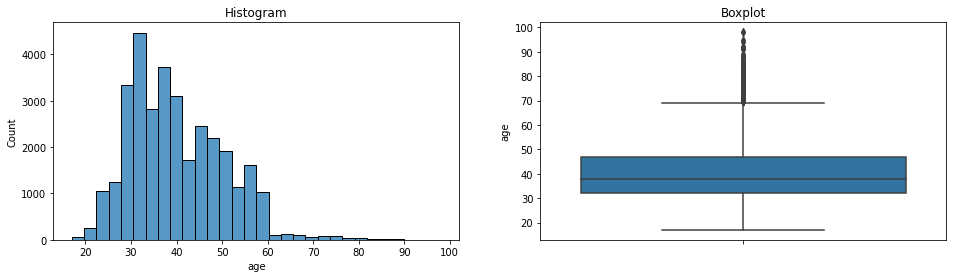


Age - After Trimming


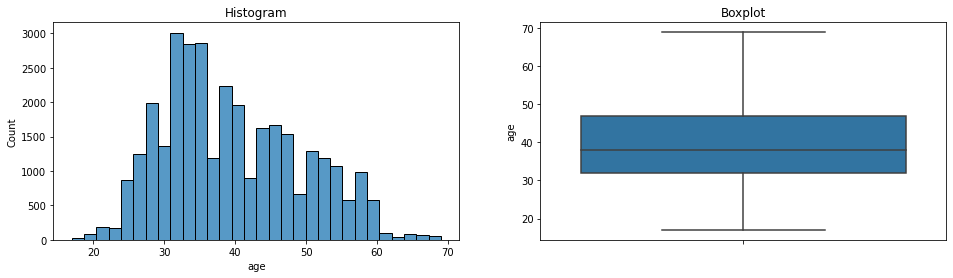


Duration - Before Capping


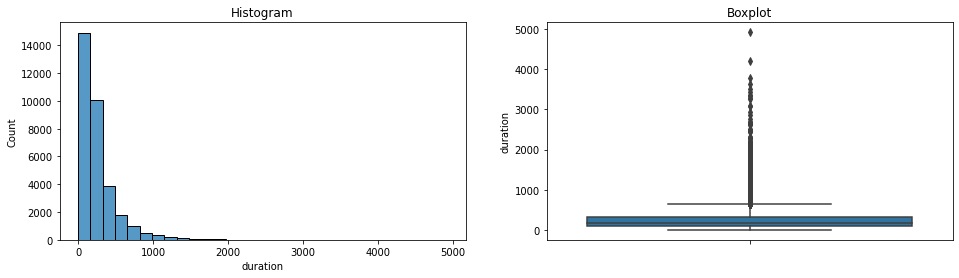


Duration - After Capping


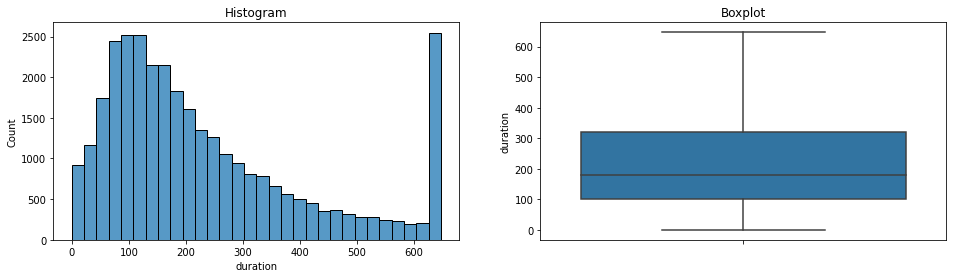


Campaign - Before Capping


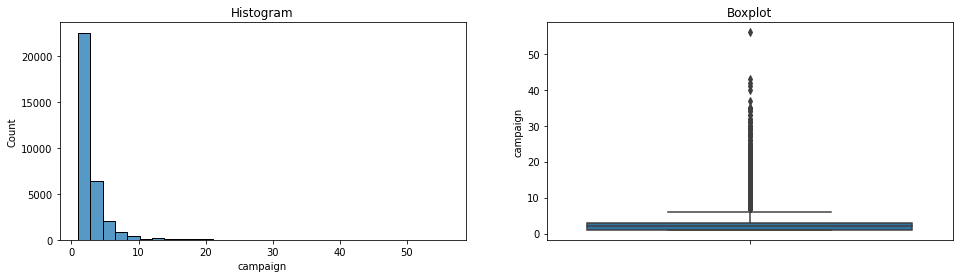


Campaign - After Capping


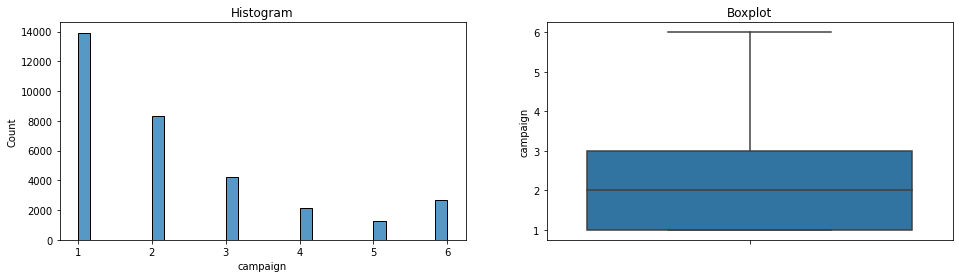


Pdays - Before Trimming


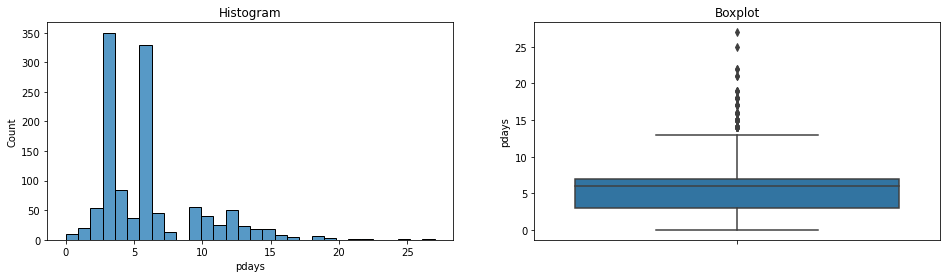


Pdays - After Trimming


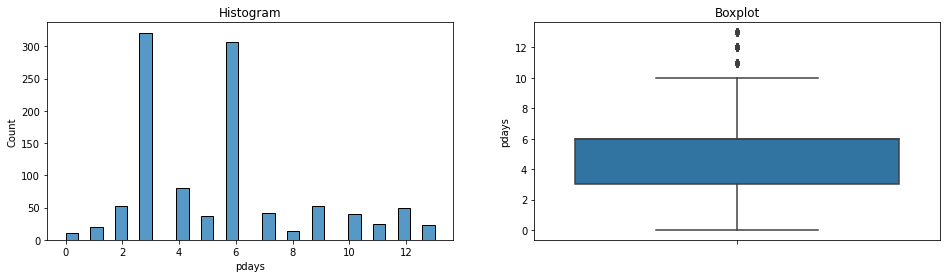


Previous - Before Capping


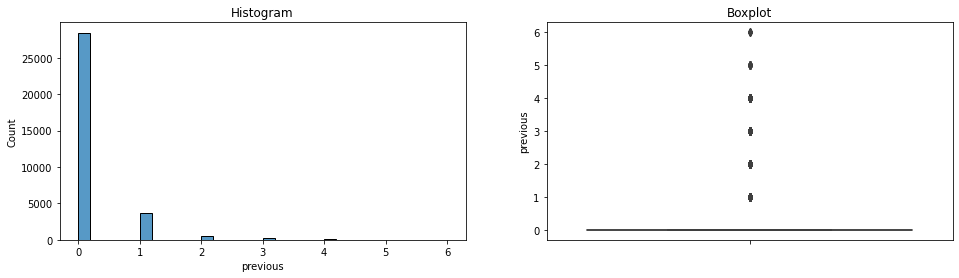


Previous - After Capping


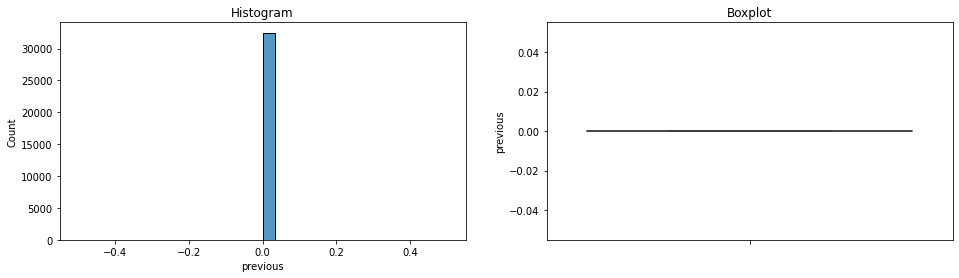

In [31]:
print('Age - Before Trimming')
diagnostic_plots(X_train, 'age')
print('\nAge - After Trimming')
diagnostic_plots(X_train_t, 'age')

print('\nDuration - Before Capping')
diagnostic_plots(X_train, 'duration')
print('\nDuration - After Capping')
diagnostic_plots(X_train_t, 'duration')

print('\nCampaign - Before Capping')
diagnostic_plots(X_train, 'campaign')
print('\nCampaign - After Capping')
diagnostic_plots(X_train_t, 'campaign')

print('\nPdays - Before Trimming')
diagnostic_plots(X_train, 'pdays')
print('\nPdays - After Trimming')
diagnostic_plots(X_train_t, 'pdays')

print('\nPrevious - Before Capping')
diagnostic_plots(X_train, 'previous')
print('\nPrevious - After Capping')
diagnostic_plots(X_train_t, 'previous')

## D. Handling Missing Values

In [32]:
X_train_t.isna().sum()

age                   0
job                   0
marital               0
education             0
default               0
housing               0
loan                  0
contact               0
month                 0
day_of_week           0
duration              0
campaign              0
pdays             31412
previous              0
poutcome              0
emp.var.rate          0
cons.price.idx        0
cons.conf.idx         0
euribor3m             0
nr.employed           0
dtype: int64

In [33]:
print('Skewness Pdays:',X_train_t['pdays'].skew())

Skewness Pdays: 0.8473294305484195


- Skew distribution in pdays column, because skewness > 0.5. So we'll fill the missing value in pdyas column with median

In [34]:
print('Median of Pdays:',X_train_t['pdays'].median())

Median of Pdays: 6.0


In [35]:
X_train_t["pdays"].fillna(value= 6 ,inplace=True)

In [36]:
X_test.isna().sum()

age                  0
job                  0
marital              0
education            0
default              0
housing              0
loan                 0
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays             7917
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
dtype: int64

In [37]:
print('Skewness Pdays:',X_test['pdays'].skew())

Skewness Pdays: 1.6332712973864283


In [38]:
X_test["pdays"].fillna(value= 6 ,inplace=True)

## E. Feature Selection

Based on EDA housing and loan didn't have a significant correlation, so we drop housing and loan column

In [39]:
X_train_t.drop(['housing', 'loan'], axis=1, inplace=True)
X_test.drop(['housing', 'loan'], axis=1, inplace=True)

## F. Splitting Columns (Numerical Columns and Categorical Columns)

In [40]:
# Get Numerical and Categorical Columns

num_columns = X_train_t.select_dtypes(include=np.number).columns.tolist()
cat_columns = X_train_t.select_dtypes(include=['object']).columns.tolist()

print('Numeric Columns : ', num_columns)
print('Categorical Columns : ', cat_columns)

Numeric Columns :  ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical Columns :  ['job', 'marital', 'education', 'default', 'contact', 'month', 'day_of_week', 'poutcome']


In [41]:
# Split on X_train

X_train_t_num = X_train_t[num_columns]
X_train_t_cat = X_train_t[cat_columns]

# Split on X_test

X_test_num = X_test[num_columns]
X_test_cat = X_test[cat_columns]

In [42]:
# Feature Scaling

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_t_num_scaled = scaler.fit_transform(X_train_t_num)
X_test_num_scaled = scaler.transform(X_test_num)

In [43]:
job_vs_target=pd.crosstab(X_train_t["job"],y_train)
stat, p, dof, expected = stats.chi2_contingency(job_vs_target)
print('p=%.3f' % (p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

p=0.000
Probably dependent


In [44]:
education_vs_target=pd.crosstab(X_train_t["education"],y_train)
stat, p, dof, expected = stats.chi2_contingency(education_vs_target)
print('p=%.3f' % (p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

p=0.000
Probably dependent


In [45]:
contact_vs_target=pd.crosstab(X_train_t["contact"],y_train)
stat, p, dof, expected = stats.chi2_contingency(contact_vs_target)
print('p=%.3f' % (p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

p=0.000
Probably dependent


In [46]:
poutcome_vs_target=pd.crosstab(X_train_t["poutcome"],y_train)
stat, p, dof, expected = stats.chi2_contingency(poutcome_vs_target)
print('p=%.3f' % (p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

p=0.000
Probably dependent


In [47]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train_t_cat_encoded = encoder.fit_transform(X_train_t_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

In [48]:
y_train_trimmed.replace({'no': 0, 'yes': 1},inplace = True)
y_test.replace({'no': 0, 'yes': 1},inplace = True)

## G. Concatenate between Numerical Columns and Categorical Columns

In [49]:
# Concate Data

X_train_final = np.concatenate([X_train_t_num_scaled, X_train_t_cat_encoded], axis=1)
X_test_final = np.concatenate([X_test_num_scaled, X_test_cat_encoded], axis=1)

In [50]:
X_train_final_2 = np.concatenate([X_train_t_num, X_train_t_cat_encoded], axis=1)
X_test_final_2 = np.concatenate([X_test_num, X_test_cat_encoded], axis=1)

In [51]:
X_train_final_df = pd.DataFrame(X_train_final, columns=[num_columns + cat_columns])
X_train_final_df

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,default,contact,month,day_of_week,poutcome
0,0.634615,0.089645,0.0,0.461538,0.0,0.6875,0.389322,0.368201,0.806393,0.877883,0.0,1.0,6.0,0.0,0.0,7.0,1.0,1.0
1,0.615385,0.231839,0.2,0.461538,0.0,1.0000,0.669135,0.338912,0.981183,1.000000,4.0,1.0,6.0,0.0,1.0,3.0,0.0,1.0
2,0.250000,0.738794,0.0,0.461538,0.0,0.6875,0.389322,0.368201,0.780322,0.877883,0.0,2.0,6.0,0.0,0.0,7.0,2.0,1.0
3,0.269231,0.204019,0.0,0.461538,0.0,1.0000,0.484412,0.615063,0.981410,1.000000,9.0,0.0,6.0,0.0,0.0,1.0,2.0,1.0
4,0.346154,0.180835,0.4,0.461538,0.0,1.0000,0.669135,0.338912,0.981410,1.000000,1.0,1.0,2.0,1.0,0.0,3.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32478,0.288462,0.160742,0.4,0.461538,0.0,0.6875,0.389322,0.368201,0.767853,0.877883,4.0,1.0,6.0,0.0,0.0,7.0,0.0,1.0
32479,0.557692,0.479134,0.2,0.461538,0.0,0.9375,0.698753,0.602510,0.957379,0.859735,4.0,1.0,6.0,0.0,1.0,6.0,3.0,1.0
32480,0.711538,0.213292,0.0,0.538462,0.0,0.0000,0.174591,0.866109,0.019270,0.203781,1.0,1.0,2.0,0.0,0.0,7.0,4.0,0.0
32481,0.730769,0.199382,0.0,0.461538,0.0,0.9375,0.698753,0.602510,0.957153,0.859735,5.0,1.0,1.0,1.0,1.0,6.0,3.0,1.0


# 7. Model Definition
---

In [52]:
logreg = LogisticRegression(random_state=33)
svc = svm.SVC(kernel='rbf')
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=33)
for_clf = RandomForestClassifier(max_depth=2, random_state=33)
neigh = KNeighborsClassifier(n_neighbors=15)
naba=GaussianNB()
xgb=XGBClassifier() 


# 8. Model Training and Model Evaluation
---

## 8.1 Logistic Regression

In [53]:
logreg.fit(X_train_final, y_train_trimmed)


LogisticRegression(random_state=33)

In [54]:
y_pred_train = logreg.predict(X_train_final)
y_pred_test = logreg.predict(X_test_final)

print(classification_report(y_train_trimmed, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     28945
           1       0.65      0.36      0.47      3538

    accuracy                           0.91     32483
   macro avg       0.79      0.67      0.71     32483
weighted avg       0.90      0.91      0.90     32483

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      7345
           1       0.56      0.53      0.55       883

    accuracy                           0.91      8228
   macro avg       0.75      0.74      0.75      8228
weighted avg       0.90      0.91      0.90      8228



## 8.2 SVM

In [55]:
svc.fit(X_train_final, y_train_trimmed)


SVC()

In [56]:
y_pred_train_svc = svc.predict(X_train_final)
y_pred_test_svc = svc.predict(X_test_final)

print(classification_report(y_train_trimmed, y_pred_train_svc))
print(classification_report(y_test, y_pred_test_svc))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     28945
           1       0.76      0.21      0.33      3538

    accuracy                           0.91     32483
   macro avg       0.84      0.60      0.64     32483
weighted avg       0.90      0.91      0.88     32483

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7345
           1       0.69      0.34      0.45       883

    accuracy                           0.91      8228
   macro avg       0.80      0.66      0.70      8228
weighted avg       0.90      0.91      0.90      8228



## 8.3 Decision Tree Classifier

In [57]:
tree_clf.fit(X_train_final_2, y_train_trimmed)

DecisionTreeClassifier(max_depth=2, random_state=33)

In [58]:
y_pred_train_tree_clf = tree_clf.predict(X_train_final_2)
y_pred_test_tree_clf = tree_clf.predict(X_test_final_2)
print(classification_report(y_train_trimmed, y_pred_train_tree_clf))
print(classification_report(y_test, y_pred_test_tree_clf))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     28945
           1       0.62      0.17      0.27      3538

    accuracy                           0.90     32483
   macro avg       0.76      0.58      0.61     32483
weighted avg       0.88      0.90      0.87     32483

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7345
           1       0.62      0.16      0.25       883

    accuracy                           0.90      8228
   macro avg       0.76      0.57      0.60      8228
weighted avg       0.88      0.90      0.87      8228



## 8.4 Random Forest Classifier

In [59]:
for_clf.fit(X_train_final_2, y_train_trimmed)

RandomForestClassifier(max_depth=2, random_state=33)

In [60]:
y_pred_train_4 = tree_clf.predict(X_train_final_2)
y_pred_test_4 = tree_clf.predict(X_test_final_2)

print(classification_report(y_train_trimmed, y_pred_train_4))
print(classification_report(y_test, y_pred_test_4))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     28945
           1       0.62      0.17      0.27      3538

    accuracy                           0.90     32483
   macro avg       0.76      0.58      0.61     32483
weighted avg       0.88      0.90      0.87     32483

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7345
           1       0.62      0.16      0.25       883

    accuracy                           0.90      8228
   macro avg       0.76      0.57      0.60      8228
weighted avg       0.88      0.90      0.87      8228



## 8.5. KNN

In [61]:
neigh.fit(X_train_final, y_train_trimmed)

KNeighborsClassifier(n_neighbors=15)

In [62]:
y_pred_train_neigh = neigh.predict(X_train_final)
y_pred_test_neigh = neigh.predict(X_test_final)

print(classification_report(y_train_trimmed, y_pred_train_neigh))
print(classification_report(y_test, y_pred_test_neigh))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     28945
           1       0.73      0.19      0.30      3538

    accuracy                           0.90     32483
   macro avg       0.82      0.59      0.63     32483
weighted avg       0.89      0.90      0.88     32483

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7345
           1       0.60      0.18      0.28       883

    accuracy                           0.90      8228
   macro avg       0.76      0.59      0.61      8228
weighted avg       0.88      0.90      0.87      8228



## 8.6 Naive Bayes

In [63]:
naba.fit(X_train_final,y_train_trimmed)

GaussianNB()

In [64]:
y_pred_train_bayes = naba.predict(X_train_final)
y_pred_test_bayes = naba.predict(X_test_final)

print(classification_report(y_train_trimmed, y_pred_train_bayes))
print(classification_report(y_test, y_pred_test_bayes))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     28945
           1       0.38      0.60      0.46      3538

    accuracy                           0.85     32483
   macro avg       0.66      0.74      0.69     32483
weighted avg       0.89      0.85      0.86     32483

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      7345
           1       0.38      0.70      0.49       883

    accuracy                           0.85      8228
   macro avg       0.67      0.78      0.70      8228
weighted avg       0.90      0.85      0.86      8228



## 8.7 XG Boost

In [65]:
xgb.fit(X_train_final,y_train_trimmed)

[23:13:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [66]:
y_pred_train_xg = xgb.predict(X_train_final)
y_pred_test_xg = xgb.predict(X_test_final)

print(classification_report(y_train_trimmed, y_pred_train_xg))
print(classification_report(y_test, y_pred_test_xg))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28945
           1       0.86      0.74      0.79      3538

    accuracy                           0.96     32483
   macro avg       0.91      0.86      0.89     32483
weighted avg       0.96      0.96      0.96     32483

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      7345
           1       0.62      0.56      0.59       883

    accuracy                           0.92      8228
   macro avg       0.78      0.76      0.77      8228
weighted avg       0.91      0.92      0.91      8228



- XGB has the highest accuracy amongst all models

## 8.8 Cross Validation & Grid Search

### 8.8.1 Logistic Regression

In [67]:
log_reg_params={'penalty':['l1','l2'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, cv=5)
grid_log_reg.fit(X_train_final, y_train_trimmed)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

In [68]:
grid_log_reg.best_params_

{'C': 10, 'penalty': 'l2'}

In [69]:
grid_log_reg.best_score_

0.9095219013550022

In [70]:
grid_log_reg_best= grid_log_reg.best_estimator_
grid_log_reg_best

LogisticRegression(C=10)

In [71]:
y_train_pred_grid_log_reg = grid_log_reg_best.predict(X_train_final)
y_test_pred_grid_log_reg = grid_log_reg_best.predict(X_test_final)

print('DT train \n', classification_report(y_train_trimmed, y_train_pred_grid_log_reg))
print('DT val \n', classification_report(y_test, y_test_pred_grid_log_reg))

DT train 
               precision    recall  f1-score   support

           0       0.93      0.98      0.95     28945
           1       0.65      0.37      0.47      3538

    accuracy                           0.91     32483
   macro avg       0.79      0.67      0.71     32483
weighted avg       0.90      0.91      0.90     32483

DT val 
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      7345
           1       0.56      0.53      0.54       883

    accuracy                           0.90      8228
   macro avg       0.75      0.74      0.74      8228
weighted avg       0.90      0.90      0.90      8228



### 8.8.2 SVM

In [72]:
svc_params={'C': [0.1,1], 'gamma': [1,0.1],'kernel': ['rbf', 'sigmoid']}
grid_svc = GridSearchCV(svm.SVC(), svc_params, cv=5)
grid_svc.fit(X_train_final, y_train_trimmed)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1], 'gamma': [1, 0.1],
                         'kernel': ['rbf', 'sigmoid']})

In [73]:
grid_svc.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [74]:
grid_svc.best_score_

0.9052428043712482

In [75]:
grid_svc_best = grid_svc.best_estimator_
grid_svc_best

SVC(C=1, gamma=0.1)

In [76]:
y_train_pred_grid_svc = grid_svc_best.predict(X_train_final)
y_test_pred_grid_svc = grid_svc_best.predict(X_test_final)

print('DT train \n', classification_report(y_train_trimmed, y_train_pred_grid_svc))
print('DT val \n', classification_report(y_test, y_test_pred_grid_svc))

DT train 
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     28945
           1       0.78      0.27      0.40      3538

    accuracy                           0.91     32483
   macro avg       0.85      0.63      0.68     32483
weighted avg       0.90      0.91      0.89     32483

DT val 
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      7345
           1       0.67      0.33      0.44       883

    accuracy                           0.91      8228
   macro avg       0.79      0.65      0.69      8228
weighted avg       0.90      0.91      0.90      8228



### 8.8.3 Decision Tree

In [77]:
params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 6, 8, 10],
    'max_depth': np.arange(2,8)
}

In [78]:
grid_dec_tree = GridSearchCV(tree_clf, param_grid = params, cv=5, scoring='f1', return_train_score=True)
grid_dec_tree.fit(X_train_final, y_train_trimmed)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=2, random_state=33),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([2, 3, 4, 5, 6, 7]),
                         'min_samples_split': [2, 4, 6, 8, 10]},
             return_train_score=True, scoring='f1')

In [79]:
grid_dec_tree.best_params_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}

In [80]:
grid_dec_tree.best_score_

0.5653773083922459

In [81]:
grid_dec_tree_best= grid_dec_tree.best_estimator_
grid_dec_tree_best

DecisionTreeClassifier(max_depth=4, random_state=33)

In [82]:
y_train_pred_grid_dec_tree = grid_dec_tree_best.predict(X_train_final)
y_test_pred_grid_dec_tree = grid_dec_tree_best.predict(X_test_final)

print('DT train \n', classification_report(y_train_trimmed, y_train_pred_grid_dec_tree))
print('DT val \n', classification_report(y_test, y_test_pred_grid_dec_tree))

DT train 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     28945
           1       0.58      0.62      0.60      3538

    accuracy                           0.91     32483
   macro avg       0.77      0.78      0.78     32483
weighted avg       0.91      0.91      0.91     32483

DT val 
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      7345
           1       0.56      0.63      0.59       883

    accuracy                           0.91      8228
   macro avg       0.76      0.79      0.77      8228
weighted avg       0.91      0.91      0.91      8228



### 8.8.4 Random Forest Classifier

In [83]:
for_clf_params = { 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 4, 6, 8, 10], 'max_depth': np.arange(2,8), 'max_features': ['auto', 'sqrt', 'log2']}

In [84]:
grid_for_clf = GridSearchCV(RandomForestClassifier(), for_clf_params)
grid_for_clf.fit(X_train_final, y_train_trimmed)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([2, 3, 4, 5, 6, 7]),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 6, 8, 10]})

In [85]:
grid_for_clf.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_split': 2}

In [86]:
grid_for_clf.best_score_

0.9132777320112124

In [87]:
grid_for_clf_best= grid_for_clf.best_estimator_
grid_for_clf_best

RandomForestClassifier(max_depth=7, max_features='sqrt')

In [88]:
y_train_pred_grid_for_clf = grid_for_clf_best.predict(X_train_final)
y_test_pred_grid_for_clf = grid_for_clf_best.predict(X_test_final)

print('DT train \n', classification_report(y_train_trimmed, y_train_pred_grid_for_clf))
print('DT val \n', classification_report(y_test, y_test_pred_grid_for_clf))

DT train 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     28945
           1       0.79      0.38      0.51      3538

    accuracy                           0.92     32483
   macro avg       0.86      0.68      0.74     32483
weighted avg       0.91      0.92      0.91     32483

DT val 
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      7345
           1       0.70      0.35      0.47       883

    accuracy                           0.91      8228
   macro avg       0.82      0.67      0.71      8228
weighted avg       0.90      0.91      0.90      8228



### 8.8.5 KNN

In [89]:
neigh_params=[{'n_neighbors': [2,3,4,5,6], 'weights': ['uniform','distance']}]

In [90]:
grid_neigh = GridSearchCV(KNeighborsClassifier(), neigh_params)
grid_neigh.fit(X_train_final, y_train_trimmed)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [2, 3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [91]:
grid_neigh.best_params_

{'n_neighbors': 4, 'weights': 'uniform'}

In [92]:
grid_neigh.best_score_

0.8945910238222871

In [93]:
grid_neigh_best = grid_neigh.best_estimator_
grid_neigh_best

KNeighborsClassifier(n_neighbors=4)

In [94]:
y_train_pred_grid_neigh = grid_neigh_best.predict(X_train_final)
y_test_pred_grid_neigh = grid_neigh_best.predict(X_test_final)

print('DT train \n', classification_report(y_train_trimmed, y_train_pred_grid_neigh))
print('DT val \n', classification_report(y_test, y_test_pred_grid_neigh))

DT train 
               precision    recall  f1-score   support

           0       0.92      0.99      0.96     28945
           1       0.86      0.29      0.43      3538

    accuracy                           0.92     32483
   macro avg       0.89      0.64      0.69     32483
weighted avg       0.91      0.92      0.90     32483

DT val 
               precision    recall  f1-score   support

           0       0.91      0.98      0.95      7345
           1       0.59      0.20      0.29       883

    accuracy                           0.90      8228
   macro avg       0.75      0.59      0.62      8228
weighted avg       0.88      0.90      0.88      8228



### 8.8.6 Naive Bayes

In [95]:
naba_params = {'var_smoothing': np.logspace(0,-9, num=100)}

In [96]:
grid_naba = GridSearchCV(GaussianNB(), naba_params, cv=5)
grid_naba.fit(X_train_final, y_train_trimmed)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])})

In [97]:
grid_naba.best_params_

{'var_smoothing': 0.01519911082952933}

In [98]:
grid_naba.best_score_

0.9018870920720514

In [99]:
grid_naba_best=grid_naba.best_estimator_
grid_naba_best

GaussianNB(var_smoothing=0.01519911082952933)

In [100]:
y_train_pred_grid_naba = grid_naba_best.predict(X_train_final)
y_test_pred_grid_naba = grid_naba_best.predict(X_test_final)

print('DT train \n', classification_report(y_train_trimmed, y_train_pred_grid_naba))
print('DT val \n', classification_report(y_test, y_test_pred_grid_naba))

DT train 
               precision    recall  f1-score   support

           0       0.91      0.98      0.95     28945
           1       0.63      0.23      0.34      3538

    accuracy                           0.90     32483
   macro avg       0.77      0.61      0.64     32483
weighted avg       0.88      0.90      0.88     32483

DT val 
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      7345
           1       0.64      0.31      0.42       883

    accuracy                           0.91      8228
   macro avg       0.78      0.64      0.68      8228
weighted avg       0.89      0.91      0.89      8228



- No significant difference in accuracy between the previous model and the model with gridsearch and cross validation. But in naive bayes model has improved, from 85% to 90% in data train and 85% to 91% in data test

# 9. Model Inference
---

XGB has the highest accuracy amongst all models, so we'll use it in the inference data

In [101]:
df_inf.isna().sum()

age                0
job                0
marital            0
education          0
default            0
housing            0
loan               0
contact            0
month              0
day_of_week        0
duration           0
campaign           0
pdays             50
previous           0
poutcome           0
emp.var.rate       0
cons.price.idx     0
cons.conf.idx      0
euribor3m          0
nr.employed        0
term_deposit       0
dtype: int64

In [102]:
df_inf["pdays"].fillna(value= 6 ,inplace=True)

In [103]:
# Split Numerical and Categorical Columns

df_inf_num = df_inf[num_columns]
df_inf_cat = df_inf[cat_columns]

In [104]:
df_inf_num_scaled = scaler.transform(df_inf_num)
df_inf_cat_encoded = encoder.transform(df_inf_cat)

In [105]:
df_inf_final = np.concatenate([df_inf_num_scaled, df_inf_cat_encoded], axis=1)

In [108]:
y_pred_inf = xgb.predict(df_inf_final)
y_pred_inf = pd.DataFrame(y_pred_inf, columns=['term_deposit_pred'])
y_pred_inf

,term_deposit_pred
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [109]:
pd.concat([df_inf, y_pred_inf], axis=1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit,term_deposit_pred
0,25,blue-collar,married,basic.9y,unknown,yes,no,telephone,jun,mon,283,5,6.0,0,nonexistent,1.4,94.465,-41.8,4.865,5228.1,no,0
1,44,technician,married,high.school,no,yes,yes,cellular,oct,mon,310,1,6.0,1,failure,-1.1,94.601,-49.5,1.000,4963.6,yes,0
2,29,technician,married,professional.course,no,yes,no,cellular,aug,fri,94,1,6.0,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no,0
3,32,admin.,single,university.degree,no,yes,no,cellular,aug,thu,12,15,6.0,0,nonexistent,1.4,93.444,-36.1,4.962,5228.1,no,0
4,38,blue-collar,married,high.school,no,no,no,telephone,jun,mon,358,3,6.0,0,nonexistent,1.4,94.465,-41.8,4.865,5228.1,no,0
5,49,housemaid,divorced,basic.6y,no,yes,no,telephone,may,wed,295,1,6.0,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no,0
6,47,technician,married,university.degree,no,no,no,cellular,aug,wed,1642,2,6.0,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,yes,0
7,27,blue-collar,single,basic.6y,no,no,yes,telephone,may,fri,146,4,6.0,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,no,0
8,31,unemployed,married,university.degree,no,yes,no,cellular,aug,tue,103,1,6.0,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no,0
9,40,admin.,divorced,high.school,no,yes,yes,cellular,jul,mon,52,10,6.0,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,0
